# Phase 3 Data Science Training Notebook

In [3]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import Input, layers, Sequential, optimizers, losses, callbacks, models
from datetime import datetime
from  matplotlib import pyplot as plt
import os

## Exploratory Data Analysis

In [8]:
# Assume tar.gz file to be extracted at project directory.
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [9]:
def get_image(cifar_data):
    image=cifar_data.reshape(3, 32, 32) / 255
    return np.swapaxes(np.swapaxes(image, 0, 1), 1, 2)

In [10]:
batch_1 = unpickle('cifar-10-batches-py/data_batch_1')
batch_2 = unpickle('cifar-10-batches-py/data_batch_2')
batch_3 = unpickle('cifar-10-batches-py/data_batch_3')
batch_4 = unpickle('cifar-10-batches-py/data_batch_4')
batch_5 = unpickle('cifar-10-batches-py/data_batch_5')

all_labels = np.concatenate((batch_1[b'labels'], batch_2[b'labels'], batch_3[b'labels'], batch_4[b'labels'], batch_5[b'labels']), axis=0)
all_data = np.concatenate((batch_1[b'data'], batch_2[b'data'], batch_3[b'data'], batch_4[b'data'], batch_5[b'data']), axis=0)

test_batch = unpickle('cifar-10-batches-py/test_batch')
test_batch_labels = np.array(test_batch[b'labels'])
test_batch_data = np.array(test_batch[b'data'])


In [11]:
print('The shape of the all batch data: ', all_data.shape)
print('The shape of the test batch data: ', test_batch_data.shape)

The shape of the all batch data:  (50000, 3072)
The shape of the test batch data:  (10000, 3072)


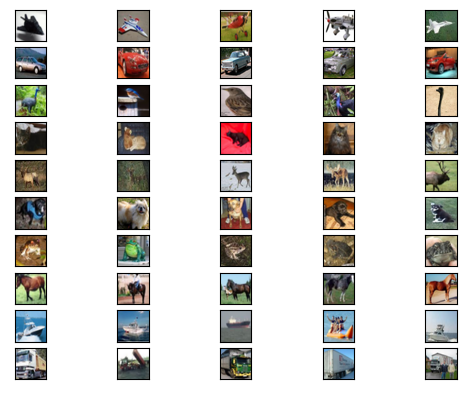

In [12]:
f=plt.figure()
for i in range(10):
    count = 0
    for j in range(len(all_labels)):
        if all_labels[j] == i:
            f.add_subplot(10, 5, 5 * i + count + 1)
            plt.imshow(get_image(all_data[j]))
            plt.xticks([])
            plt.yticks([])
            count += 1
            if count == 5:
                break

I choose label bird (2) for probability that the item/animal is there

# Data Processing

In [13]:
train_labels = np.array([])
train_data = None
for i in range(10):
    count = 0
    for j in range(len(all_labels)):
        if all_labels[j] == i:
            if train_data is None:
                train_data = all_data[j].reshape(1, -1)
            else:
                train_data = np.append(train_data, all_data[j].reshape(1, -1), axis=0)
            count += 1
            if i == 2:
                train_labels = np.append(train_labels, 1)
                if count == 5000:
                    break
            elif i < 6:
                train_labels = np.append(train_labels, 0)
                if count == 556:
                    break
            else:
                train_labels = np.append(train_labels, 0)
                if count == 555:
                    break
train_data = np.swapaxes(np.swapaxes(train_data.reshape(train_data.shape[0], 3, 32, 32), 1, 2), 2, 3)

test_labels = np.array([])
test_data = None
for i in range(10):
    count = 0
    for j in range(len(test_batch_labels)):
        if test_batch_labels[j] == i:
            if test_data is None:
                test_data = test_batch_data[j].reshape(1, -1)
            else:
                test_data = np.append(test_data, test_batch_data[j].reshape(1, -1), axis=0)
            count += 1
            if i == 2:
                test_labels = np.append(test_labels, 1)
                if count == 1000:
                    break
            elif i == 0:
                test_labels = np.append(test_labels, 0)
                if count == 112:
                    break
            else:
                test_labels = np.append(test_labels, 0)
                if count == 111:
                    break
test_data = np.swapaxes(np.swapaxes(test_data.reshape(test_data.shape[0], 3, 32, 32), 1, 2), 2, 3)

print('The shape of the training set: ', train_data.shape)
print('The shape of the testing set: ', test_data.shape)

The shape of the training set:  (10000, 32, 32, 3)
The shape of the testing set:  (2000, 32, 32, 3)


In [14]:
train_x = train_data
train_y = train_labels
test_x = test_data
test_y = test_labels

labels = [0 for i in range(2)]
for label in train_labels:
    labels[int(label)] += 1
print('Number of images in each label in training set: ', labels)

labels = [0 for i in range(2)]
for label in test_labels:
    labels[int(label)] += 1
print('Number of images in each label in testing set: ', labels)

Number of images in each label in training set:  [5000, 5000]
Number of images in each label in testing set:  [1000, 1000]


# Data Modelling

In [15]:

log_dir = "output/logs/" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

# Callbacks for QoL.
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystop_callback = callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

In [12]:
def generateModel():
    """
    Make a Keras Sequential Model.
    Feel free to change the layout of the layers.

    Read more about keras here: https://keras.io/api/
    Tensorflow setup adapted here: https://www.tensorflow.org/tutorials/quickstart/beginner
    """
    model = Sequential(name="Image_Recognition_Model")
    model.add(Input(shape=(32, 32, 3)))  # Input layer.

    # Example pre-processing layer.
    model.add(layers.Rescaling(scale=1./255, name="Normaliser"))

    model.add(layers.Conv2D(filters=32, kernel_size=3, strides=2,
                            input_shape=(32, 32, 3),
                            activation='relu',
                            padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(filters=64, kernel_size=3, strides=2,
                            activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))

    # Output layer.
    model.add(layers.Dense(1, activation="sigmoid", name="Output_Probability"))

    model.compile(
        optimizer=optimizers.SGD(),
        loss=losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )

    return model


In [13]:
model = generateModel()

model.fit(train_x, train_y,
    validation_data=(test_x, test_y),
    epochs=50000,
    batch_size=1000, # Set this to a lower number if your computer spec is bad.
    callbacks=[tensorboard_callback, earlystop_callback],
    # verbose=0 # Uncomment this line to reduce the printing on console.
)

Epoch 1/50000
10/10 [==============================] - 2s 166ms/step - loss: 0.7649 - accuracy: 0.5506 - val_loss: 0.6915 - val_accuracy: 0.5165
Epoch 2/50000
10/10 [==============================] - 1s 147ms/step - loss: 0.6975 - accuracy: 0.5901 - val_loss: 0.6903 - val_accuracy: 0.5775
Epoch 3/50000
10/10 [==============================] - 1s 146ms/step - loss: 0.6778 - accuracy: 0.6155 - val_loss: 0.6892 - val_accuracy: 0.5365
Epoch 4/50000
10/10 [==============================] - 1s 150ms/step - loss: 0.6603 - accuracy: 0.6322 - val_loss: 0.6889 - val_accuracy: 0.5080
Epoch 5/50000
10/10 [==============================] - 1s 145ms/step - loss: 0.6462 - accuracy: 0.6404 - val_loss: 0.6886 - val_accuracy: 0.5025
Epoch 6/50000
10/10 [==============================] - 1s 144ms/step - loss: 0.6414 - accuracy: 0.6490 - val_loss: 0.6884 - val_accuracy: 0.5015
Epoch 7/50000
10/10 [==============================] - 1s 143ms/step - loss: 0.6357 - accuracy: 0.6514 - val_loss: 0.6887 - val_ac

In [14]:
model.save('output/my_model')

INFO:tensorflow:Assets written to: output/my_model\assets


INFO:tensorflow:Assets written to: output/my_model\assets


# Advanced Features

1. Apply hyperparameter tuning to your model so you can find out the best possible model compilation parameters for accuracy.

In [14]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

In [15]:
HP_NUM_FILTERS = hp.HParam('num_filters', hp.Discrete([16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

log_dir = "output/logs/hparam_tuning/" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

with tf.summary.create_file_writer(log_dir).as_default():
  hp.hparams_config(
    hparams=[HP_NUM_FILTERS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [16]:
def train_test_model(hparams):
    model = Sequential(name="Image_Recognition_Model")
    model.add(Input(shape=(32, 32, 3)))  # Input layer.

    # Example pre-processing layer.
    model.add(layers.Rescaling(scale=1./255, name="Normaliser"))

    model.add(layers.Conv2D(filters=hparams[HP_NUM_FILTERS], kernel_size=3, strides=2,
                            activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Dropout(hparams[HP_DROPOUT]))
    model.add(layers.Conv2D(filters=hparams[HP_NUM_FILTERS] * 2, kernel_size=3, strides=2,
                            activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Dropout(hparams[HP_DROPOUT]))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))

    # Output layer.
    model.add(layers.Dense(1, activation="sigmoid", name="Output_Probability"))

    model.compile(
        optimizer=hparams[HP_OPTIMIZER],
        loss=losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )

    model.fit(train_x, train_y,
        validation_data=(test_x, test_y),
        epochs=50000,
        batch_size=1000, # Set this to a lower number if your computer spec is bad.
        callbacks=[tensorboard_callback, earlystop_callback, hp.KerasCallback(log_dir, hparams)],
        # verbose=0 # Uncomment this line to reduce the printing on console.
    )

    _, accuracy = model.evaluate(test_x, test_y)

    return accuracy

In [17]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [18]:
session_num = 0

for num_filters in HP_NUM_FILTERS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_FILTERS: num_filters,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "/run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run(log_dir + run_name, hparams)
      session_num += 1

--- Starting trial: /run-0
{'num_filters': 16, 'dropout': 0.1, 'optimizer': 'adam'}
Epoch 1/50000
10/10 [==============================] - 1s 85ms/step - loss: 0.6968 - accuracy: 0.5900 - val_loss: 0.6856 - val_accuracy: 0.5050
Epoch 2/50000
10/10 [==============================] - 1s 70ms/step - loss: 0.6055 - accuracy: 0.6823 - val_loss: 0.6832 - val_accuracy: 0.5070
Epoch 3/50000
10/10 [==============================] - 1s 73ms/step - loss: 0.5694 - accuracy: 0.7086 - val_loss: 0.6815 - val_accuracy: 0.5095
Epoch 4/50000
10/10 [==============================] - 1s 66ms/step - loss: 0.5513 - accuracy: 0.7182 - val_loss: 0.6764 - val_accuracy: 0.5345
Epoch 5/50000
10/10 [==============================] - 1s 69ms/step - loss: 0.5379 - accuracy: 0.7283 - val_loss: 0.6709 - val_accuracy: 0.5740
Epoch 6/50000
10/10 [==============================] - 1s 61ms/step - loss: 0.5260 - accuracy: 0.7377 - val_loss: 0.6677 - val_accuracy: 0.6025
Epoch 7/50000
10/10 [==============================]

3. Make a python application/function that can evaluate your model when you give it any PNG and/or JPEG image. This application should be able to resize your images to 32x32 before having the model evaluate said image.



In [27]:
model = models.load_model('output/my_model')

In [55]:
def load_resize(image_path, image_name):
    src = cv2.imread(image_path + image_name, cv2.IMREAD_UNCHANGED)
    output = cv2.resize(src, (32, 32))
    # cv2.imwrite(image_path + 'resized_' + image_name, output)
    output_RGB = output[:,:,[2,1,0]]
    return output_RGB

In [99]:
def app(image_path, image_name):
    resized_img = load_resize(image_path, image_name)
    
    plt.figure(figsize=(2.0, 2.0))
    plt.imshow(resized_img)
    plt.show()

    print("Prediction: ")
    if len(resized_img.shape) == 3:
        resized_img = resized_img[np.newaxis, :]
    pred_result = model.predict(resized_img)[0, 0]

    print('The probability that a bird is present in this image is: ', pred_result)
    if pred_result >= 0.5:
        print("so a bird is there.")
    else:
        print('So a bird is not there.')
    
    print("\nTrue label: " + image_name[:-5])

    if (pred_result >= 0.5 and image_name[:-5] == 'bird') or (pred_result < 0.5 and image_name[:-5] != 'bird'):
        print("\nCORRECT!")
        return True
    else:
        print("\nWRONG!")
        return False

######################################################################


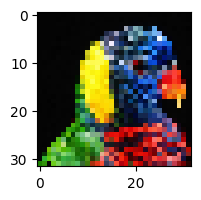

Prediction: 
1/1 [==============================] - 0s 10ms/step
The probability that a bird is present in this image is:  0.97087
so a bird is there.

True label: bird

CORRECT!
######################################################################
######################################################################


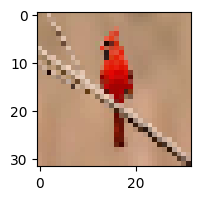

Prediction: 
1/1 [==============================] - 0s 12ms/step
The probability that a bird is present in this image is:  0.96339
so a bird is there.

True label: bird

CORRECT!
######################################################################
######################################################################


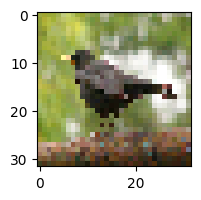

Prediction: 
1/1 [==============================] - 0s 12ms/step
The probability that a bird is present in this image is:  0.5889225
so a bird is there.

True label: bird

CORRECT!
######################################################################
######################################################################


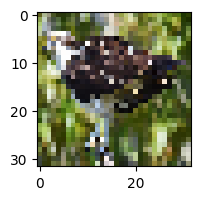

Prediction: 
1/1 [==============================] - 0s 11ms/step
The probability that a bird is present in this image is:  0.17722541
So a bird is not there.

True label: bird

WRONG!
######################################################################
######################################################################


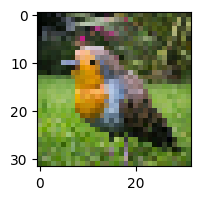

Prediction: 
1/1 [==============================] - 0s 11ms/step
The probability that a bird is present in this image is:  0.6673234
so a bird is there.

True label: bird

CORRECT!
######################################################################
######################################################################


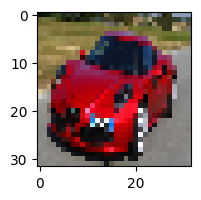

Prediction: 
1/1 [==============================] - 0s 12ms/step
The probability that a bird is present in this image is:  0.0114354305
So a bird is not there.

True label: car

CORRECT!
######################################################################
######################################################################


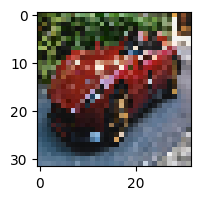

Prediction: 
1/1 [==============================] - 0s 11ms/step
The probability that a bird is present in this image is:  0.0040417574
So a bird is not there.

True label: car

CORRECT!
######################################################################
######################################################################


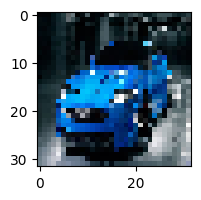

Prediction: 
1/1 [==============================] - 0s 9ms/step
The probability that a bird is present in this image is:  0.00068598776
So a bird is not there.

True label: car

CORRECT!
######################################################################
######################################################################


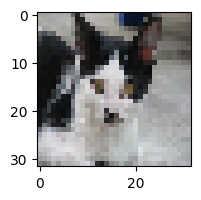

Prediction: 
1/1 [==============================] - 0s 12ms/step
The probability that a bird is present in this image is:  0.049792286
So a bird is not there.

True label: cat

CORRECT!
######################################################################
######################################################################


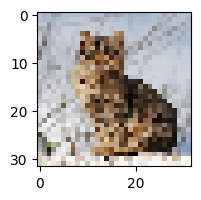

Prediction: 
1/1 [==============================] - 0s 12ms/step
The probability that a bird is present in this image is:  0.1123362
So a bird is not there.

True label: cat

CORRECT!
######################################################################
######################################################################


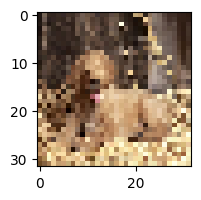

Prediction: 
1/1 [==============================] - 0s 12ms/step
The probability that a bird is present in this image is:  0.009796066
So a bird is not there.

True label: dog

CORRECT!
######################################################################
######################################################################


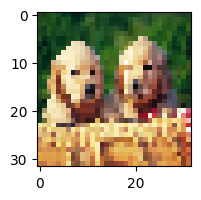

Prediction: 
1/1 [==============================] - 0s 11ms/step
The probability that a bird is present in this image is:  0.085055135
So a bird is not there.

True label: dog

CORRECT!
######################################################################
######################################################################


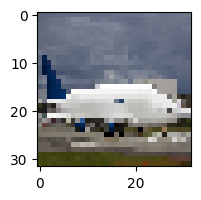

Prediction: 
1/1 [==============================] - 0s 11ms/step
The probability that a bird is present in this image is:  0.005534781
So a bird is not there.

True label: plane

CORRECT!
######################################################################

The model has  0.9230769230769231 accuracy with given images.


In [101]:
input_dir = 'input/'

image_names = os.listdir(input_dir)
correct_count = 0
total_count = 0
for image_name in image_names:
    print("######################################################################")
    if app(input_dir, image_name):
        correct_count += 1
    total_count += 1
    print("######################################################################")
print('\nThe model has ', correct_count / total_count, 'accuracy with given images.')